<a href="https://colab.research.google.com/github/mooglol/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module1-statistics-probability-and-inference/LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-09-16 22:01:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-09-16 22:01:10 (279 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
import numpy as np
import seaborn as sns
from matplotlib import style
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
import scipy.stats
from scipy.stats import ttest_1samp

In [3]:
# Load Data

import pandas as pd

df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [6]:
df = df.replace({'?':np.NaN, 'n':0, 'y':1})

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
dem = df[df['party'] == 'democrat']
rep = df[df['party'] == 'republican']

In [12]:
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [13]:
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [14]:
df.isnull().sum()

party                     0
handicapped-infants      12
water-project            48
budget                   11
physician-fee-freeze     11
el-salvador-aid          15
religious-groups         11
anti-satellite-ban       14
aid-to-contras           15
mx-missile               22
immigration               7
synfuels                 21
education                31
right-to-sue             25
crime                    17
duty-free                28
south-africa            104
dtype: int64

In [24]:
dem['duty-free'].mean()

0.6374501992031872

In [25]:
rep['duty-free'].mean()

0.08974358974358974

In [23]:
ttest_ind(dem['duty-free'], rep['duty-free'], nan_policy='omit')

Ttest_indResult(statistic=12.853146132542978, pvalue=5.997697174347365e-32)

In [26]:
dem['education'].mean()

0.14457831325301204

In [27]:
rep['education'].mean()

0.8709677419354839

In [28]:
ttest_ind(rep['education'], dem['education'], nan_policy='omit')

Ttest_indResult(statistic=20.500685724563073, pvalue=1.8834203990450192e-64)

In [29]:
ttest_ind(rep['water-project'], dem['water-project'], nan_policy='omit')

Ttest_indResult(statistic=0.08896538137868286, pvalue=0.9291556823993485)

In [30]:
rep['water-project'].mean()

0.5067567567567568

In [31]:
dem['water-project'].mean()

0.502092050209205

In [32]:
dem['synfuels'].mean()

0.5058823529411764

In [34]:
dem['synfuels'].isnull().sum()

12

In [35]:
len(dem['synfuels']) - dem['synfuels'].isnull().sum()

255

1) Null Hypothesis:

In 1-sample t-tests YOU GET TO CHOOSE YOUR NULL HYPOTHESIS

H0 : 0.50 - There is 50% democrat support for this bill

2) Alternative Hypothesis

Ha :  x¯=0  - There is zero support for the budget bill among democrats.

3) Confidence Level: 95% or .95

In [38]:
ttest_1samp(dem['synfuels'], 0.5, nan_policy='omit')

Ttest_1sampResult(statistic=0.18751153526716705, pvalue=0.8514092819865365)

4) t-statistic: 0.1875

5) p-value of 0.8514

Conclusion: Due to a p-value of 0.8514 I fail to reject the null hypothesis that democrat support is 50% and conclude that democrat support is not zero.

In [0]:
import statistics 
from statistics import stdev

# Mean duty-free Support

xbar1 = dem['duty-free'].mean()
xbar2 = rep['duty-free'].mean()

# Standard Deviation Support
# Use without NaNs

s1 = np.nanstd(dem['duty-free'])
s2 = np.nanstd(rep['duty-free'])

# Sample Szies of the two samples

n1 = len(dem['duty-free']) - dem['duty-free'].isnull().sum()
n2 = len(rep['duty-free']) - rep['duty-free'].isnull().sum()

In [0]:
dem_sup = np.random.normal(xbar1, s1, n1)
rep_sup = np.random.normal(xbar2, s2, n2)

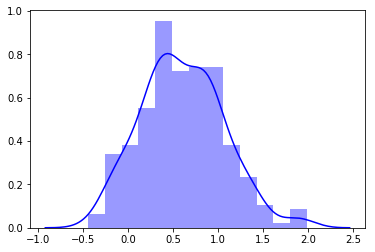

In [64]:
import seaborn as sns
ax = sns.distplot(dem_sup, color='b')

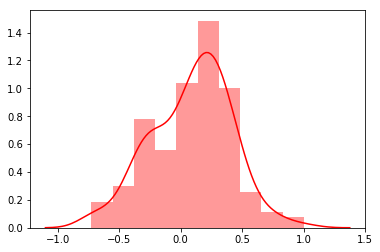

In [65]:
import seaborn as sns
ax = sns.distplot(rep_sup, color='r')

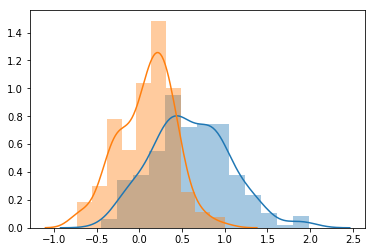

In [66]:
import matplotlib.pyplot as plt
fix, ax = plt.subplots()
for sample in [dem_sup, rep_sup]:
  sns.distplot(sample)